In [ ]:
import os
import sys
import pandas as pd
import numpy as np 
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import tensorflow as tf

print("OS: ", sys.platform)
print("Python: ", sys.version)
print("Tensorflow: ", tf.__version__)
print("Numpy: ", np.__version__)

%load_ext autoreload
%autoreload 2

OS:  linux
Python:  3.6.3 (default, Oct  3 2017, 21:45:48) 
[GCC 7.2.0]
Tensorflow:  1.8.0
Numpy:  1.14.3


### Data

In [ ]:
!wget https://raw.githubusercontent.com/miguelgfierro/sciblog_support/master/Time_Series_Forecasting_of_Stock_Price/data/MSFT_2012_2017.csv

--2018-06-15 21:55:18--  https://raw.githubusercontent.com/miguelgfierro/sciblog_support/master/Time_Series_Forecasting_of_Stock_Price/data/MSFT_2012_2017.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 105688 (103K) [text/plain]
Saving to: ‘MSFT_2012_2017.csv’

MSFT_2012_2017.csv  100%[===================>] 103.21K  --.-KB/s    in 0.01s   

2018-06-15 21:55:18 (7.21 MB/s) - ‘MSFT_2012_2017.csv’ saved [105688/105688]



In [ ]:
DATA = os.path.join('./', 'MSFT_2012_2017.csv')
EPOCHS = 10
TEST_SIZE = 0.3
TIME_AHEAD = 1 #prediction step
BATCH_SIZE = 1
UNITS = 10
SEQUENCE = 10

In [ ]:
df = pd.read_csv(DATA)
df = df.drop(['Adj Close', 'Volume'], axis=1)
print(df.shape)
df.head()

(1509, 5)


,Date,Open,High,Low,Close
0,2012-01-03,26.549999,26.959999,26.389999,26.770000
1,2012-01-04,26.820000,27.469999,26.780001,27.400000
2,2012-01-05,27.379999,27.730000,27.290001,27.680000
3,2012-01-06,27.530001,28.190001,27.530001,28.110001
4,2012-01-09,28.049999,28.100000,27.719999,27.740000


In [ ]:
# helper functions

import matplotlib.pyplot as plt
from IPython.display import SVG, display

def plot_series(values, xlabel=None, ylabel=None, color='b', legend=None):
    xx = np.arange(1, len(values) + 1, 1)
    plt.plot(xx, values, color, label=legend)
    plt.legend(loc = 'upper left')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()
    

def plot_series_prediction(true_values, train_predict, test_predict, time_ahead=1, title=None,
                           xlabel=None, ylabel=None, color=['green','red','blue'], legend=[None,None,None]):    
    TOOLS = 'pan,wheel_zoom,box_zoom,reset,save,box_select'
    #x axis
    xx = np.array(range(true_values.shape[0]))
    xx1 = np.array(range(time_ahead,len(train_predict)+time_ahead))
    xx2 = np.array(range(len(train_predict)+(time_ahead*2)+1,len(true_values)-1))
    
    #figure
    plt.plot(xx, true_values.squeeze())
    plt.plot(xx1, train_predict.squeeze())
    plt.plot(xx2, test_predict.squeeze())
    
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(['true', 'training set', 'test predict'], loc='upper left')
    plt.show()

    
def to_1dimension(df, step_size):
    X, y = [], []
    for i in range(len(df)-step_size-1):
        data = df[i:(i+step_size), 0]
        X.append(data)
        y.append(df[i + step_size, 0])
    X, y = np.array(X), np.array(y)
    X = np.reshape(X, (X.shape[0], 1, X.shape[1]))
    return X, y

(1509,)


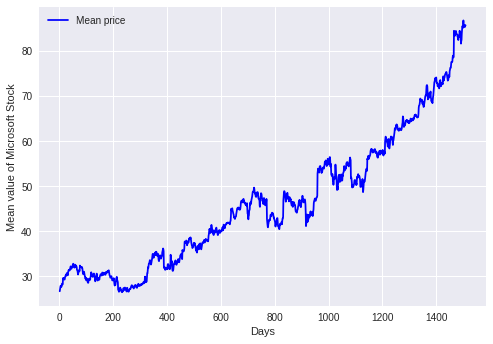

In [ ]:
mean_price = df.mean(axis = 1)
print(mean_price.shape)
plot_series(mean_price, xlabel='Days', ylabel='Mean value of Microsoft Stock', color='b', legend='Mean price')

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1)) #other typical scale values are -1,1
mean_price = scaler.fit_transform(np.reshape(mean_price.values, (len(mean_price),1)))

In [ ]:
train, test = train_test_split(mean_price, test_size=TEST_SIZE, shuffle=False)
print(train.shape)
print(test.shape)

(1056, 1)
(453, 1)


In [ ]:
X_train, y_train = to_1dimension(train, TIME_AHEAD)
X_test, y_test = to_1dimension(test, TIME_AHEAD)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
# (1054, 10, 1)-> (10,1)

(1054, 1, 1) (1054,)
(451, 1, 1) (451,)


### LSTM

In [ ]:
def create_symbol(X, model_name='LSTM', units=10, activation='linear', time_ahead=1, dropout=True):
    # with tf.variable_scope("RNN"):
    if model_name == 'LSTM':
        if dropout:
            cell = tf.contrib.rnn.DropoutWrapper(
                              # tf.contrib.rnn.BasicLSTMCell(units, forget_bias=1.0), #LSTMCell(units),
                              tf.contrib.rnn.LSTMCell(units),
                              output_keep_prob=0.8)
        else:
            cell = tf.contrib.rnn.BasicLSTMCell(units, forget_bias=1.0) #LSTMCell(units)
        
        outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

    elif model_name == 'GRU':
        cell = tf.contrib.rnn.GRUCell(units)
        outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)
    else:
        raise ValueError("Wrong model name")
    sym = tf.layers.dense(outputs[-1], 1, activation=None, name='output') #activation=None (linear activation)
    return sym

In [ ]:
tf.reset_default_graph()

# Place-holders
X = tf.placeholder(tf.float32, shape=[None, 1, TIME_AHEAD])
y = tf.placeholder(tf.float32, shape=[None])

# with sess.as_default():
sym = create_symbol(X, model_name='LSTM', units=UNITS, time_ahead=TIME_AHEAD, dropout=False)
loss = tf.reduce_mean(tf.squared_difference(sym, y)) #mse
optimizer = tf.train.AdamOptimizer()
model = optimizer.minimize(loss)

init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

# training
for i in range(EPOCHS):
    ii = 0
    while(ii + BATCH_SIZE) <= len(X_train):
        X_batch = X_train[ii:ii+BATCH_SIZE,:,:]
        y_batch = y_train[ii:ii+BATCH_SIZE]
        sess.run(model, feed_dict={X:X_batch, y:y_batch})
        ii += BATCH_SIZE
    loss_train = sess.run(loss, feed_dict={X: X_batch, y: y_batch})
    print('Epoch {}/{}'.format(i+1, EPOCHS), ' Current loss: {}'.format(loss_train))

y_guess = np.zeros(y_test.shape[0], dtype=np.float32)
ii = 0
while(ii + BATCH_SIZE) <= len(X_test):
    X_batch = X_test[ii:ii+BATCH_SIZE,:,:]
    output = sess.run(sym, feed_dict={X:X_batch})
    y_guess[ii:ii+BATCH_SIZE] = output
    ii += BATCH_SIZE

Epoch 1/10  Current loss: 6.818496331106871e-05
Epoch 2/10  Current loss: 4.780407834914513e-05
Epoch 3/10  Current loss: 2.394820512563456e-05
Epoch 4/10  Current loss: 1.7207441487698816e-05
Epoch 5/10  Current loss: 1.0099686733155977e-05
Epoch 6/10  Current loss: 5.176257673156215e-06
Epoch 7/10  Current loss: 3.1750994367030216e-06
Epoch 8/10  Current loss: 2.5216079393430846e-06
Epoch 9/10  Current loss: 2.396187710473896e-06
Epoch 10/10  Current loss: 2.4966823275462957e-06


In [ ]:
y_test_inv = scaler.inverse_transform([y_test])
pred_test = scaler.inverse_transform([y_guess])
score = math.sqrt(mean_squared_error(y_test_inv, pred_test))
print('Test RMSE: %.2f' % (score))

Test RMSE: 3.05


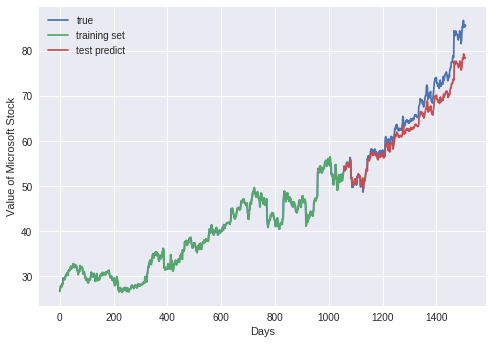

In [ ]:
mean_price_inv = scaler.inverse_transform(mean_price)
train_set = mean_price_inv[:X_train.shape[0]]
plot_series_prediction(mean_price_inv, train_set, pred_test.T, time_ahead=TIME_AHEAD,
                       title='LSTM prediction', xlabel='Days', ylabel='Value of Microsoft Stock', 
                       legend=['True value','Training set','Test prediction'])